In [2]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,Activation, BatchNormalization, ReLU, Concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar100, cifar10
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Loading CIFAR10 dataset
The dataset contains 50,000 training images and 10,000 test images

In [3]:
(train_data, _), (test_data, _) = cifar10.load_data()


170500096/170498071 [==============================] - 2s 0us/step


Normalizing images

In [4]:
train_data = train_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

# Adding Gaussian Noise


In [5]:
def noise(data):
    noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)    #Gaussian noise with mean 0 and standard deviation 0.1
    data = data + noise
    data = np.clip(data, 0., 1.)                                     #Pixel values clipped to 0-1 after adding noise
    return data

In [6]:
train_noise = noise(train_data)
test_noise = noise(test_data)

Original and Noisy Images

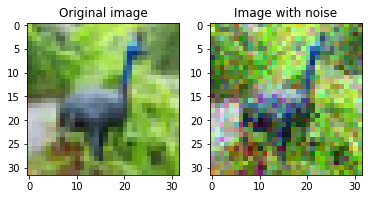

In [7]:
idx = 6
plt.subplot(1,2,1)
plt.imshow(train_data[idx])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_noise[idx])
plt.title('Image with noise')
plt.show()

# Autoencoder

In [8]:
def conv_block(x, filters, kernel_size, strides=2):
    x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def deconv_block(x, filters, kernel_size):
    x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

In [9]:
def denoising_autoencoder():
    dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
    conv_block1 = conv_block(dae_inputs, 32, 3)
    conv_block2 = conv_block(conv_block1, 64, 3)
    conv_block3 = conv_block(conv_block2, 128, 3)
    conv_block4 = conv_block(conv_block3, 256, 3)
    conv_block5 = conv_block(conv_block4, 256, 3, 1)

    deconv_block1 = deconv_block(conv_block5, 256, 3)
    merge1 = Concatenate()([deconv_block1, conv_block3])
    deconv_block2 = deconv_block(merge1, 128, 3)
    merge2 = Concatenate()([deconv_block2, conv_block2])
    deconv_block3 = deconv_block(merge2, 64, 3)
    merge3 = Concatenate()([deconv_block3, conv_block1])
    deconv_block4 = deconv_block(merge3, 32, 3)

    final_deconv = Conv2DTranspose(filters=3,
                       kernel_size=3,
                       padding='same')(deconv_block4)

    dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
  
    return Model(dae_inputs, dae_outputs, name='dae')

In [11]:
dae = denoising_autoencoder()
dae.compile(loss='mse', optimizer='adam')

checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)

dae.fit(train_noise,train_data,validation_data=(test_noise, test_data),epochs=40,batch_size=100,callbacks=[checkpoint])

Epoch 1/40
499/500 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 00001: val_loss improved from inf to 0.00279, saving model to best_model.h5
500/500 [==============================] - 25s 50ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 2/40
499/500 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 00002: val_loss improved from 0.00279 to 0.00215, saving model to best_model.h5
500/500 [==============================] - 25s 50ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 3/40
499/500 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 00003: val_loss improved from 0.00215 to 0.00205, saving model to best_model.h5
500/500 [==============================] - 25s 50ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 4/40
499/500 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 00004: val_loss did not improve from 0.00205
500/500 [==============================] - 25s 50ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/40
500/500 [===

Denoising Results for test data

Text(0.5, 1.0, 'denoised')

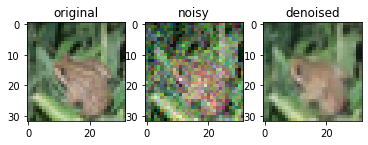

In [13]:
dae.load_weights('best_model.h5')
test_data_denoised = dae.predict(test_noise)
idx = 4
plt.subplot(1,3,1)
plt.imshow(test_data[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_noise[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')